# BASTRA GRID ANALYSIS
This notebook will cover the GRID scenario data analysis based on BASTRA simulator.

Author: Alvaro Paricio. sept.2016

## Scenarios
* Reference scenario: Grid_NoBastra
    * A GRID map routing traffic without BASTRA map distribution mechanisms.
## References
* For Wilcoxon tests:
    * http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
    * https://gist.github.com/mblondel/1761714

### Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.lines as mlines
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu

import sklearn as sk
import pandas as pd

### Functions

#### Function str_vals_percent
Given two values, print them with their percent difference

In [2]:
def str_vals_percent( n1, n2 ):
    return "[" + "{0:.2f}".format(n1) + "," + "{0:.2f}".format(n2) +"] "+ "{0:.2f}".format((n2-n1)*100/n1) + "%" 

#### Function dataset_obtain_unique_fleets
Extract unique values for 'veh_types' column from the datasets.

Support 0,1,2 datasets. Easy to extend to more dataserts. Not needed by now.

In [3]:
def dataset_obtain_unique_fleets( *ds ):
    size = len(ds)
    if( len(ds) == 0):
        return []
    if( len(ds) == 1):
        return ds[0]['veh_type'].unique()
    if( len(ds) == 2):
        vt1 = ds[0]['veh_type'].unique()
        vt2 = ds[1]['veh_type'].unique()
        return list(set().union(vt2, vt2))

#### Function dataset_filter_per_veh_type
Filter a dataset per type of veh_type

In [4]:
def dataset_filter_per_veh_type(ds, vt):
    return ds.loc[ ds['veh_type']==vt ]

#### Function draw_histogram
Plots an histogram based on the dataset.

In [5]:
def draw_histogram( name, ds_raw ):
    ds = ds_raw.loc[ ds_raw['t_arrival_secs'] > 0 ]
    # ds_raw.head()
    travel_times = ds['t_traveltime_secs']

    cols = 80
    plt.figure(figsize=(18,8)) 
    y_vals, x_bins, patches = plt.hist(travel_times, cols, normed=0, facecolor='green', alpha=0.50)
    x_mean = np.mean(travel_times)
    x_median = np.median(travel_times)
    y_mean = np.mean(y_vals)
    y_median = np.median(y_vals)
    r_mean = np.mean(ds['route_path_num'])
    r_median = np.median(ds['route_path_num'])
    # l_mean = np.mean(ds['route_length'])
    # l_median = np.median(ds['route_length'])
    l_mean = 1
    l_median = 1

    # add a 'best fit' line
    y1_vals = np.append( y_vals, y_vals[cols-1] )

    x2_mean = [ x_mean for i in y1_vals ]
    x3_median = [ x_median for i in y1_vals ]
    y2_mean = [ y_mean for i in x_bins ]
    y3_median = [ y_median for i in x_bins ]

    # print( "X-VALS: ", len(x_bins), " ", x_bins.__repr__, )
    # print( "Y_VALS: ", len(y1_vals), " ", y1_vals.__repr__, )
    # print( "X-MEAN: ", len(x2_mean), " ", x2_mean.__repr__, )
    # print( "X-MEDIAN: ", len(x3_median), " ", x3_median.__repr__, )

    print(
        "Experiment:", name, "\n",
        "Trips Total:", ds_raw['id'].count(), "\n",
        "Trips Completed:", travel_times.count(), "\n",
        "   * Travel time (mean):", x_mean, "\n",
        "  * Travel time (median):", x_median, "\n",
        "  * Route lengths (mean):", l_mean, "\n",
        "  * Route lengths (median):", l_median, "\n",
        "  * Route paths (mean):", r_mean, "\n",
        "  * Route paths (median):", r_median, "\n",
        )

    line_estimation = plt.plot(x_bins, y1_vals, 'r-', label='Estimation', linewidth=2, color='darkgreen')
    line_mean = plt.plot(x2_mean, y1_vals, label='Mean', linestyle='-', linewidth=2, color='blue')
    line_median = plt.plot(x3_median, y1_vals, label='Median', linestyle='-', linewidth=2, color='red')

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    # plt.title(r'$\mathrm{Histogram\ of\ Travel Times: }\ $' + name )
    plt.title("Travel Times Histogram: "+name )
    mean_line = mlines.Line2D([], [], color='blue', markersize=1, label='Mean')
    median_line = mlines.Line2D([], [], color='red', markersize=1, label='Median')
    plt.legend(handles=[median_line, mean_line], bbox_to_anchor=(1.15, 0.9))

    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    plt.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

#### Function draw_2histograms
Plots the comparison between two overlapped histograms based on the datasets.

In [6]:
def draw_2histograms( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):
    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ]
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ]

    travel_times1 = ds1['t_traveltime_secs']
    travel_times2 = ds2['t_traveltime_secs']
    travel_times = [ travel_times1, travel_times2 ]
    
    cols = 80
    fig, ax = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    
    # y_vals1, x_bins1, patches1 = ax.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = ax.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'blue'], alpha=0.30, histtype='bar')
    
    # first histogram ------------------------------------
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    # second histogram ------------------------------------
    x_mean2   = np.mean(travel_times2)
    x_median2 = np.median(travel_times2)
    y_mean2   = np.mean(y_vals2)
    y_median2 = np.median(y_vals2)
    r_mean2   = np.mean(ds2['route_path_num'])
    r_median2 = np.median(ds2['route_path_num'])
    # l_mean2   = np.mean(ds2['route_length'])
    # l_median2 = np.median(ds2['route_length'])
    l_mean2   = 1
    l_median2 = 1
    
    # add a 'best fit' line
    y1_vals2 = np.append( y_vals2, y_vals2[cols-1] )

    x2_mean2   = [ x_mean2   for i in y1_vals2 ]
    x3_median2 = [ x_median2 for i in y1_vals2 ]
    y2_mean2   = [ y_mean2   for i in x_bins ]
    y3_median2 = [ y_median2 for i in x_bins ]
    print(
        "=== ", title, " ============================== \n",
        "Trips Total:", str_vals_percent(ds_raw1['id'].count(), ds_raw2['id'].count() ), "\n",
        "Trips Completed:", str_vals_percent(travel_times1.count(),travel_times2.count()), "\n",
        "  * Travel time (mean)    :",    str_vals_percent( x_mean1, x_mean2), "\n",
        "  * Travel time (median)  :",   str_vals_percent( x_median1, x_median2), "\n",
        # "  * Route lengths (mean)  :",   str_vals_percent( l_mean1, l_mean2), "\n",
        # "  * Route lengths (median):", str_vals_percent( l_median1, l_median2), "\n",
        "  * Route paths (mean)    :",     str_vals_percent( r_mean1, r_mean2), "\n",
        "  * Route paths (median)  :",   str_vals_percent( r_median1, r_median2), "\n"
        )

    line_estimation1 = ax.plot(x_bins, y1_vals1, 'r-', label='Estimation', linewidth=2, color='darkgreen')
    line_estimation2 = ax.plot(x_bins, y1_vals2, 'r-', label='Estimation', linewidth=2, color='darkblue')

    max_y = np.linspace(0, max( max(y_vals1), max(y_vals2)), num=len(x_bins))
    line_mean1 = ax.plot(x2_mean1, max_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = ax.plot(x3_median1, max_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    line_mean2 = ax.plot(x2_mean2, y1_vals2, label='Mean', linestyle='--', linewidth=2, color='darkblue')
    line_median2 = ax.plot(x3_median2, max_y, label='Median', linestyle='-', linewidth=2, color='darkblue')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label='1:Mean')
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label='1:Median')
    mean_line2   = mlines.Line2D([], [], linestyle='--',color='darkblue',  markersize=1, label='2:Mean')
    median_line2 = mlines.Line2D([], [], linestyle='-', color='darkblue',  markersize=1, label='2:Median')
    ax.legend(handles=[median_line1, mean_line1, median_line2, mean_line2], bbox_to_anchor=(1.15, 0.9))

    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    ax.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()

#### Function process_scenario
Uploads results from scenario execution and plots an histogram based on the dataset.
* Select only those vehicles that finish the trip, i.e. have arrive time > 0.

In [7]:
def process_scenario( path, experiment ):
    datafile = path + "/experiments/" + experiment + ".csv"
    # print( "DATAFILE: ", datafile )
    # ds means "dataset"
    ds_raw = pd.read_csv(datafile)
    draw_histogram( experiment, ds_raw )

#### Function compare_scenarios
Uploads results from 2 scenario executions and plotting the histogram curves based on the dataset.
* Select only those vehicles that finish the trip, i.e. have arrive time > 0.

In [12]:
def compare_scenarios( path, label1, experiment1, label2, experiment2 ):
    datafile1 = path + "/experiments/" + experiment1 + ".csv"
    datafile2 = path + "/experiments/" + experiment2 + ".csv"
    # print( "DATAFILE: ", datafile )
    # ds means "dataset"
    ds_raw1 = pd.read_csv(datafile1)
    ds_raw2 = pd.read_csv(datafile2)
    
    veh_types = dataset_obtain_unique_fleets( ds_raw1, ds_raw2 )
    
    print(
        "Scenario: ", label1, " <--> ", label2, "\n",
        "Experiments: ", experiment1, " <--> ", experiment2, "\n"
        )
    if ( len(veh_types) > 0 ):
      for vt in veh_types:
        ds_raw1b = dataset_filter_per_veh_type(ds_raw1, vt)
        ds_raw2b = dataset_filter_per_veh_type(ds_raw2, vt)
        draw_2histograms( "VEHICLE TYPE: "+vt,
                    label1, experiment1, ds_raw1b, label2, experiment2, ds_raw2b )

    draw_2histograms( "FULL DATA SET",
                      label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 )

Scenario:  GRID/BASTRA deactivated  <-->  GRID/BASTRA activated 
 Experiments:  data_Grid_noBastra_160930_104052  <-->  data_Grid_161005_111230 

===  VEHICLE TYPE: car  ============================== 
 Trips Total: [2745.00,2745.00] 0.00% 
 Trips Completed: [2745.00,2745.00] 0.00% 
   * Travel time (mean)    : [280.08,195.26] -30.29% 
   * Travel time (median)  : [187.00,174.00] -6.95% 
   * Route paths (mean)    : [14.66,14.69] 0.20% 
   * Route paths (median)  : [13.00,13.00] 0.00% 



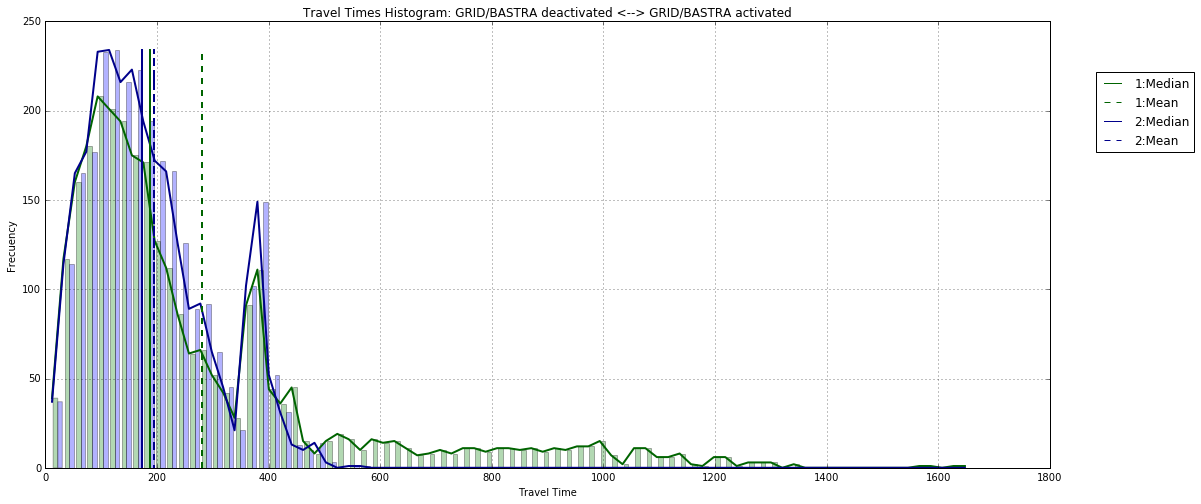

===  VEHICLE TYPE: motorcycle  ============================== 
 Trips Total: [655.00,655.00] 0.00% 
 Trips Completed: [655.00,655.00] 0.00% 
   * Travel time (mean)    : [277.46,193.64] -30.21% 
   * Travel time (median)  : [187.00,168.00] -10.16% 
   * Route paths (mean)    : [15.00,15.04] 0.20% 
   * Route paths (median)  : [13.00,13.00] 0.00% 



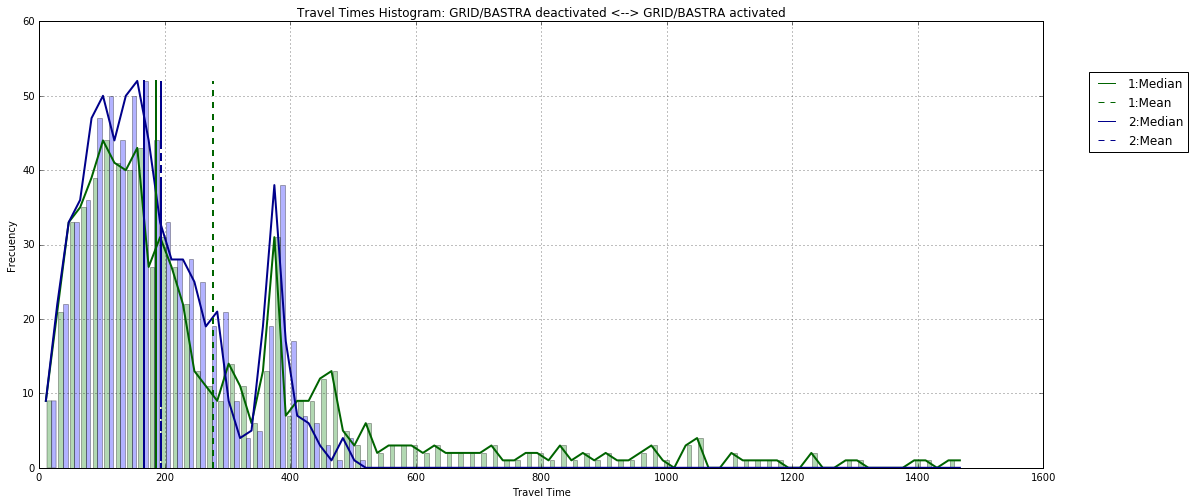

===  FULL DATA SET  ============================== 
 Trips Total: [3400.00,3400.00] 0.00% 
 Trips Completed: [3400.00,3400.00] 0.00% 
   * Travel time (mean)    : [279.58,194.95] -30.27% 
   * Travel time (median)  : [187.00,173.00] -7.49% 
   * Route paths (mean)    : [14.73,14.76] 0.20% 
   * Route paths (median)  : [13.00,13.00] 0.00% 



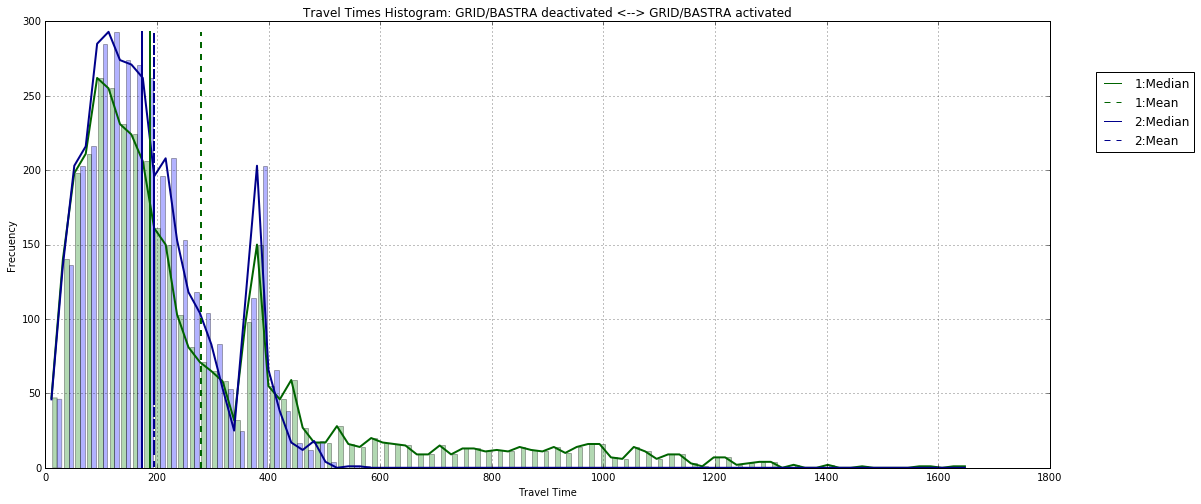

In [13]:
compare_scenarios( "/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra",
                "GRID/BASTRA deactivated", "data_Grid_noBastra_160930_104052",
                "GRID/BASTRA activated", "data_Grid_161005_111230" )

In [21]:
path = "/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
experiment1 = "data_Grid_noBastra_160930_104052"
datafile1 = path + "/experiments/" + experiment1 + ".csv"
datafile2 = path + "/routelengths/" + "grid.net.xml.edges.csv"
ds_raw1 = pd.read_csv(datafile1)
ds_raw2 = pd.read_csv(datafile2)
ds_raw1.head()
# ds_raw2.head()

,id,veh_type,t_depart_secs,t_arrival_secs,t_traveltime_secs,origin,destiny,route_detail,route_path_num,is_attended,has_finished
0,2304,car,0,243,243,1/11to2/11,11/3to12/3,1/11to2/11:2/11to3/11:3/11to4/11:4/11to5/11:5/...,19,False,True
1,3126,motorcycle,0,159,159,bottom7to7/0,10/9to10/10,bottom7to7/0:7/0to8/0:8/0to9/0:9/0to10/0:10/0t...,14,False,True
2,74,car,0,382,382,left15to0/15,15/0tobottom15,left15to0/15:0/15to1/15:1/15to2/15:2/15to3/15:...,32,False,True
3,65,car,0,385,385,left15to0/15,15/0tobottom15,left15to0/15:0/15to1/15:1/15to2/15:2/15to3/15:...,32,False,True
4,690,car,0,37,37,13/7to14/7,14/6to14/5,13/7to14/7:14/7to14/6:14/6to14/5:,3,False,True


## Simulation: GRID basic
Apply 2 weighted maps with penalty to routes, inside a network with GRID topology. Maps will be applied during all the simulation. Only 50% of the vehicles will use the system.

**Scenario**
* Name = "Grid"
* Basic reference GRID scenario.
* Execution date: 160926_124432
* Process time: 781 sec
* Platform: MAC-PRO OS-X Darwin

**Simulation Time**
* Begin = 0
* End = 10000

**SUMO Traffic**
* Network:
    * Grid style: 16x16
    * File = "../scenes/Grid/grid.net.xml"
* Vehicle Types:
    * car (weight=4 -> 80%)
    * motorcycle (weight=1 -> 20%)
* Demand:
    * Traffic background:
        * Time: full simulation
        * Volume: 3000 vehicles
        * Distribution: O/D random (normal)
    * Traffic flows:
        * Time: full simulation
        * 4 traffic flows end2end of grid.
        * Volume: 100 vehicles

**Bastra parameters**
* Logit = 0,5
* Use_blance = true
* foresight_steps = 1 <-- Number of edges in the planned route to be scanned to consider jam.
* foresight_tries = 3 <-- Number of trials to achieve a new route that avoids jam.
* foresight_halting = 3 <-- Size of vehicles queued to understand that there is a jam. 
* foresight_penalty = 50.0 <-- Weight-factor to apply to an edge in the rerouting algorithm, to force duarouter to over-weight this edge selection and thus avoid selection.
* Commands:
    * **Weighted maps**
        * Apply during all the simulation
        * 2 weighted maps, applying 50% to each vehicle type (2) with weights_factor=3 (x3) in the selected routes. So "edge weight = travel_time * weight_factor"
            * file="../scenes/Grid/maps/map1.pen.map.xml" prob="0.50" tag="motorcycle"
            * file="../scenes/Grid/maps/map2.pen.map.xml" prob="0.50" tag="motorcycle"
            * file="../scenes/Grid/maps/map1.pen.map.xml" prob="0.50" tag="car"
            * file="../scenes/Grid/maps/map2.pen.map.xml" prob="0.50" tag="car"

In [ ]:
 process_scenario("/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra",
                  "data_Grid_161005_111230" )

## Simulation: GRID no Bastra (I)
Execute the simulation without Bastra rerouting mechanism.

**Scenario**
* Name = "Grid"
* Basic reference GRID scenario.
* Execution date: 160928_235551
* Process time: 621 sec
* Platform: MAC-PRO OS-X Darwin

**Simulation Time**
* Begin = 0
* End = 10000

**SUMO Traffic**
* Network:
    * Grid style: 16x16
    * File = "../scenes/Grid/grid.net.xml"
* Vehicle Types:
    * car (weight=4 -> 80%)
    * motorcycle (weight=1 -> 20%)
* Demand:
    * Traffic background:
        * Time: full simulation
        * Volume: 3000 vehicles
        * Distribution: O/D random (normal)
    * Traffic flows:
        * Time: full simulation
        * 4 traffic flows end2end of grid.
        * Volume: 100 vehicles

**Bastra parameters**
* Logit = 0
* Use_balance = false
* foresight_steps = 0 <-- Number of edges in the planned route to be scanned to consider jam.
* foresight_tries = 0 <-- Number of trials to achieve a new route that avoids jam.
* foresight_halting = 0 <-- Size of vehicles queued to understand that there is a jam. 
* foresight_penalty = 1 <-- Weight-factor to apply to an edge in the rerouting algorithm, to force duarouter to over-weight this edge selection and thus avoid selection.
* Commands:
    * **Weighted maps**
        * NONE

In [ ]:
process_scenario( "/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra",
                 "data_Grid_noBastra_160930_104052" )